In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms

from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights

import os
import struct
import numpy as np

import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [26]:
def read_idx(filename):
    """Read IDX file format"""
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# **DATASET PROCESS**

In [27]:

class FaceMaskDataset(Dataset):

	def __init__(self, root_dir, random_seed=42, image_size=224):

		self.root_dir = root_dir
		self.image_size = image_size

		if not os.path.exists(self.root_dir):
			raise RuntimeError(f"Dataset not found at {self.root_dir}.")


		self.transform = transforms.Compose([
        	transforms.Resize((self.image_size, self.image_size)),
        	transforms.ToTensor(),
        	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

		self.data = []
		self.labels = []

		for label, class_name in tqdm(enumerate(['With-Mask','Wihout-Mask'])):
			class_dir = os.path.join(self.root_dir, class_name)
			image_paths = glob.glob(os.path.join(class_dir,'*.jpg'))
			self.data.extend(image_paths)
			self.labels.extend([label] * len(image_paths))

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		image_path = self.data[idx]
		label = self.labels[idx]
		image = Image.open(image_path).convert('RGB')

		if self.transform:
			image = self.transform(image)

		return image, label




# **TRAINING**

In [28]:
batch_size = 32
test_batch_size = 32
train_dataset = FaceMaskDataset(root_dir='/kaggle/input/dataset-face-mask-classification/Face-Mask-Classification/Dataset')
test_dataset  = FaceMaskDataset(root_dir='/kaggle/input/dataset-face-mask-classification/Face-Mask-Classification/Dataset')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset))
model = model.to(device)

2it [00:00, 2160.90it/s]
2it [00:00, 1991.60it/s]


# **Fungsi Loss dan Algoritma optimizer**

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# **Menghitung jumlah parameter yang dioptimasi (Update)**

In [30]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

Total parameters: 11.23M
Trainable parameters: 11.23M


In [31]:
num_epoch = 10
train_losses = []
test_losses = []

for epoch in range(num_epoch):
	model.train()

	train_loss = 0

	for data, labels in tqdm(train_loader):

		data, labels = data.to(device), labels.to(device)
		bs = data.size()[0]
		optimizer.zero_grad()

		outputs = model(data)
		loss = criterion(outputs, labels)

		loss.backward()

		optimizer.step()

		train_loss += loss.item() * data.size(0)

	model.eval()

	correct = 0
	total = 0
	test_loss = 0

	with torch.no_grad():
		for data, labels in tqdm(test_loader):
			data, labels = data.to(device), labels.to(device)
			bs = data.size()[0]
			outputs = model(data)

			loss = criterion(outputs, labels)
			test_loss += loss.item() * data.size(0)

			_, preds = torch.max(outputs, 1)
			correct += (preds == labels).sum().item()

			total += labels.size(0)

	acc = correct / total
	avg_train_loss = train_loss / len(train_dataset)
	avg_test_loss = test_loss / len(test_dataset)

	train_losses.append(avg_train_loss)
	test_losses.append(avg_test_loss)

	print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")

torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'Face-Mask-Model.pth')

100%|██████████| 4/4 [00:00<00:00, 10.91it/s]


Epoch 1: Train Loss 3.6813, Test Loss 3.7420, Test Acc 0.1700


100%|██████████| 4/4 [00:00<00:00, 10.33it/s]


Epoch 2: Train Loss 3.0449, Test Loss 3.4831, Test Acc 0.4800


100%|██████████| 4/4 [00:00<00:00, 11.15it/s]


Epoch 3: Train Loss 2.5221, Test Loss 3.1248, Test Acc 0.7800


100%|██████████| 4/4 [00:00<00:00, 11.07it/s]


Epoch 4: Train Loss 2.0474, Test Loss 2.6947, Test Acc 0.8700


100%|██████████| 4/4 [00:00<00:00, 10.90it/s]


Epoch 5: Train Loss 1.6320, Test Loss 2.2203, Test Acc 0.9500


100%|██████████| 4/4 [00:00<00:00, 11.16it/s]


Epoch 6: Train Loss 1.2620, Test Loss 1.7024, Test Acc 0.9600


100%|██████████| 4/4 [00:00<00:00, 11.92it/s]


Epoch 7: Train Loss 0.9563, Test Loss 1.2968, Test Acc 0.9600


100%|██████████| 4/4 [00:00<00:00, 12.17it/s]


Epoch 8: Train Loss 0.6989, Test Loss 1.0911, Test Acc 0.9600


100%|██████████| 4/4 [00:00<00:00, 10.44it/s]


Epoch 9: Train Loss 0.4796, Test Loss 0.7327, Test Acc 0.9700


100%|██████████| 4/4 [00:00<00:00,  9.22it/s]


Epoch 10: Train Loss 0.3304, Test Loss 0.5585, Test Acc 0.9700


# **MODEL EVALUATION**

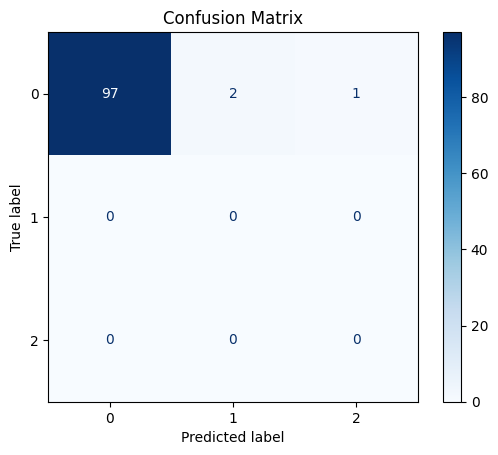

In [32]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, 
    f1_score, classification_report
)
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# **LOST RESULT**

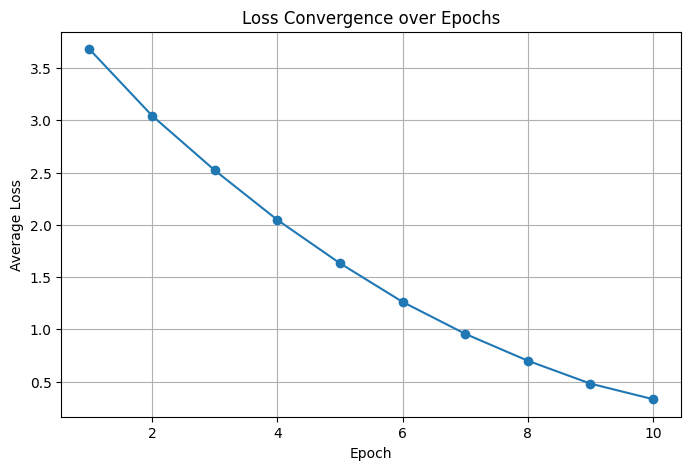

In [33]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epoch + 1), train_losses, marker='o')
plt.title('Loss Convergence over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

In [34]:
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

for i in range(len(TP)):
    print(f"Kelas {i}: FPR = {FPR[i]:.4f}, TPR (Recall) = {TPR[i]:.4f}")

Accuracy: 0.9700
Precision (macro): 0.3333
Recall (macro): 0.3233
F1-Score (macro): 0.3283

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       100
          22       0.00      0.00      0.00         0
          95       0.00      0.00      0.00         0

    accuracy                           0.97       100
   macro avg       0.33      0.32      0.33       100
weighted avg       1.00      0.97      0.98       100

Kelas 0: FPR = nan, TPR (Recall) = 0.9700
Kelas 1: FPR = 0.0200, TPR (Recall) = nan
Kelas 2: FPR = 0.0100, TPR (Recall) = nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

# **GRAFIK**

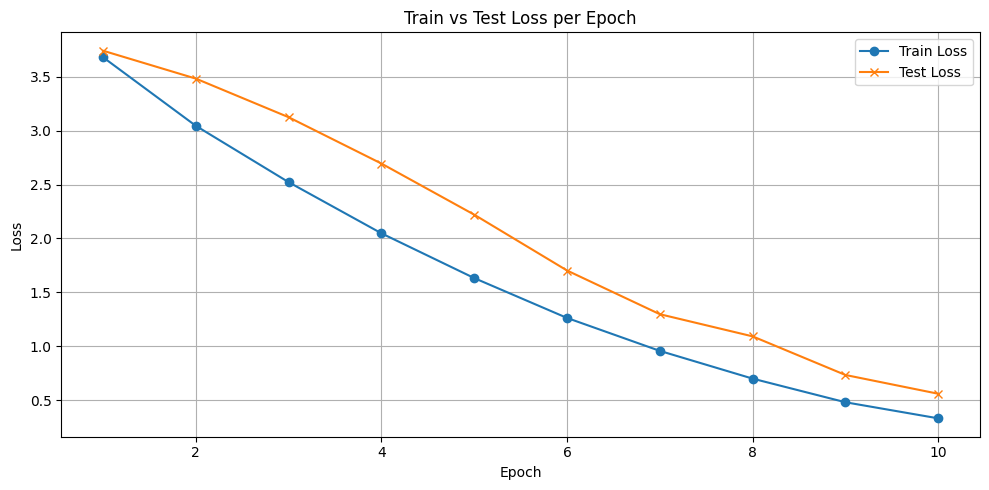

In [35]:
epochs = range(1, num_epoch + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
torch.save(model.state_dict(), 'model_cnn_mnist.pth')
# model.load_state_dict(torch.load('cnn_mnist.pth'))

torch.save(model, 'cnn_mnist_full.pth')
# model = torch.load('cnn_mnist_full.pth')

# **IMAGE PREDICT** 

Prediction: With-Mask


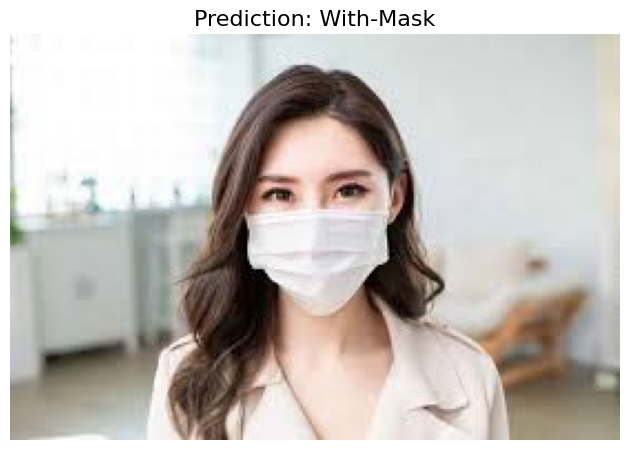

In [37]:
def load_model(weight_path, num_classes, device):
    checkpoint = torch.load(weight_path, map_location=device)

    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, checkpoint['model_state_dict']['fc.weight'].size(0))  # fix
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, device, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_class = class_names[pred.item()]
    return predicted_class, image

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Gantilah dengan label sesuai urutan di dataset ImageFolder
    class_names = ['With-Mask','Without-Mask']

    # Load model
    model = load_model('/kaggle/working/Face-Mask-Model.pth', num_classes=len(class_names), device=device)

    # Ganti path gambar sesuai kebutuhan
    img_path = '/kaggle/input/images-predict/PredictDataset/1-Predictimage.jpg'
    predicted_label, image = predict_image(img_path, model, device, class_names)

    print(f"Prediction: {predicted_label}")

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.tight_layout()
    plt.show()